# Autoencoder for MNIST in Pytorch Lightning

In this notebook,you will train an autoencoder for the MNIST dataset, which is a dataset of handwritten digits. This is the last exercise where we will provide a structured skeleton. For future exercises, we will only provide the dataset, task as well as a test scenario for you to challenge yourself against your peers on our leaderboards.

You will use the PyTorch Lightning framework which makes everything much more convenient! In case you haven't done yet, you should definitely check out the **PyTorch Lightning Introduction** in **Exercise 7**! However, you will mostly design the network architectures as well as be left of to choose suitable hyperparameters for the task at handy, so superficial knowledge of pytorch lightning will suffice.

## What we will do:

One application of autoencoders is unsupervised pretraining with unlabeled data and then finetuning the encoder with labeled data. This can increase our performance if there is only little labeled data but a lot of unlabeled data available.

In this exercise you use the MNIST dataset with 60,000 images of handwritten digits, but you do not have all the labels available.

You will then train our autoencoder to reproduce the unlabeled images. 

Then you will transfer the pretrained encoder weights and finetune a classifier on the labeled data for classifying the handwritten digits. This is called **transfer learning**.

**Note**: If you are running this in a google colab notebook, we recommend you enable GPU usage:

> **Runtime** â€†â€†â†’â€†â€† **Change runtime type** â€†â€†â†’â€†â€† **Hardware Accelerator: GPU**

If you are running in colab, you should install the dependencies by running the following cell:

In [1]:
#!pip uninstall pytorch-lightning
#!pip install pytorch-lightning

# Imports

In [2]:
import numpy as np
import os
import matplotlib.pyplot as plt

import torch

from torchvision import transforms
import pytorch_lightning as pl
from exercise_code.image_folder_dataset import ImageFolderDataset
from pytorch_lightning.loggers import TensorBoardLogger
torch.manual_seed(42)

%load_ext autoreload
%autoreload 2

<div class="alert alert-warning">
    <h3>Note: Google Colab</h3>
    <p>
In case you don't have a GPU, you can run this notebook on Google Colab where you can access a GPU for free, but, of course, you can also run this notebook on your CPU.
         </p>
</div>

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


## Setup TensorBoard
In exercise 07 you've already learned how to use TensorBoard. Let's use it again to make the debugging of our network and training process more convenient! Throughout this notebook, feel free to add further logs or visualizations to your TensorBoard!

In [4]:
%load_ext tensorboard
%tensorboard --logdir lightning_logs --port 6005

Reusing TensorBoard on port 6005 (pid 6369), started 4:24:50 ago. (Use '!kill 6369' to kill it.)

# 1. The MNIST Dataset

First, you download the dataset. MNIST is a dataset of 60,000 images depicting handwritten digits. However, as with most datasets, labeling is a costly process and therefore we are left in a pickle.

A good starting point is to label a small subset of your images. You either do this yourself but in this instance we consider the case where you hired another student to do it for you. After writing a labeling tool and some time, you are provided with 300 labeled images of which 100 will be used for training, 100 for validation, and 100 for testing. A problematic small number...

Feel free to define some transforms now or later (you can also pass without any transforms).

**Note**: We do **NOT** apply any transformations to test set at the time of final evaluation on the server.

In [5]:
########################################################################
# TODO: Feel free to define transforms                                 #
########################################################################

def transform(img):
    return img

########################################################################
#                           END OF YOUR CODE                           #
########################################################################


i2dl_exercises_path = os.path.dirname(os.path.abspath(os.getcwd()))
mnist_root = os.path.join(i2dl_exercises_path, "datasets", "mnist")


tmp1 = torch.load(mnist_root+"/training.pt")
tmp2 = torch.load(mnist_root+'/test.pt')

torch.save(tmp2[0][200:300].float(),mnist_root+"/train_images.pt")
torch.save(tmp2[1][200:300],mnist_root+"/train_labels.pt")

torch.save(tmp2[0][:100].float(),mnist_root+'/val_images.pt')
torch.save(tmp2[1][:100],mnist_root+'/val_labels.pt')

torch.save(tmp2[0][100:200].float(),mnist_root+'/test_images.pt')
torch.save(tmp2[1][100:200],mnist_root+'/test_labels.pt')

torch.save(tmp1[0][:-500].float(),mnist_root+"/unlabeled_train_images.pt")
torch.save(tmp1[0][-500:].float(),mnist_root+'/unlabeled_val_images.pt')


train = ImageFolderDataset(root=mnist_root,images='train_images.pt',labels='train_labels.pt',force_download=False,verbose=True,transform=transform)
val = ImageFolderDataset(root=mnist_root,images='val_images.pt',labels='val_labels.pt',force_download=False,verbose=True,transform=transform)
test = ImageFolderDataset(root=mnist_root,images='test_images.pt',labels='test_labels.pt',force_download=False,verbose=True,transform=transform)

# We also set up the unlabeled images which we will use later
unlabeled_train = ImageFolderDataset(root=mnist_root,images='unlabeled_train_images.pt',force_download=False,verbose=True,transform=transform)
unlabeled_val = ImageFolderDataset(root=mnist_root,images='unlabeled_val_images.pt',force_download=False,verbose=True,transform=transform)

Found dataset folder. Skipped downloading. If you face issues, please re-download the dataset using
'--force_download=True'
http://i2dl.vc.in.tum.de/static/data/mnist.zip
Found dataset folder. Skipped downloading. If you face issues, please re-download the dataset using
'--force_download=True'
http://i2dl.vc.in.tum.de/static/data/mnist.zip
Found dataset folder. Skipped downloading. If you face issues, please re-download the dataset using
'--force_download=True'
http://i2dl.vc.in.tum.de/static/data/mnist.zip
Found dataset folder. Skipped downloading. If you face issues, please re-download the dataset using
'--force_download=True'
http://i2dl.vc.in.tum.de/static/data/mnist.zip
Found dataset folder. Skipped downloading. If you face issues, please re-download the dataset using
'--force_download=True'
http://i2dl.vc.in.tum.de/static/data/mnist.zip


The dataset consists of tuples of 28x28 pixel PIL images and a label that is an integer from 0 to 9. 

Let's turn a few of the images into numpy arrays, to look at their shape and visualize them and see if the labels we paid for are correct.

The shape of our greyscale images:  (28, 28)


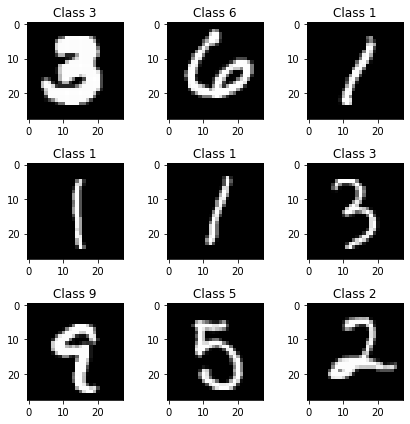

In [6]:
plt.rcParams['figure.figsize'] = (6,6) # Make the figures a bit bigger

for i in range(9):
    image = np.array(train[i][0].squeeze()) # get the image of the data sample
    label = train[i][1] # get the label of the data sample
    plt.subplot(3,3,i+1)
    plt.imshow(image, cmap='gray', interpolation='none')
    plt.title("Class {}".format(label))
    
plt.tight_layout()
print('The shape of our greyscale images: ', image.shape)

<div class="alert alert-warning">
    <h3>Note: Starting Simple</h3>
    <p>
Regardless of the size of our dataset, the first step we have to take is to evaluate the performance of a simple classifier. Always approach a problem with a simple approach first and go from there to see which changes are helping you.
         </p>
</div>

# 2. A Simple Classifier

In `exercise_code/models.py` we prepared all classes for you which you will finalize throughout the notebook to build an Autoencoder and an image classifier with Pytorch Lightning. If you are unfamiliar with Pytorch Lightning, you can check out the notebook from the last exercise.

![network_split](img/network_split.png)

## 2.1 The Encoder

Different to previous models, we are going to split up our model into two parts: the so called `encoder` and the `classifier`. The `classifier` has a static task as it will output our predictions given a one-dimensional input. The `encoder`'s task is to extract meaningful information out of our input so that the classifier can make a proper decision. Right now however, both networks will be consisting of linear layers coupled with auxiliary ones and therefore won't be too different in their design. This split-up will be relevant later, e.g., by using convolutional layers which are introduced in the lecture. We are going to set up the `encoder` now. 

Think about a good network architecture. You're completely free here and can come up with any network you like! (\*)

Have a look at the documentation of `torch.nn` at https://pytorch.org/docs/stable/nn.html to learn how to use this module to build your network!

Then implement your architecture: initialize it in `__init__()` and assign it to `self.model`. This is particularly easy using `nn.Sequential()` which you only have to pass the list of your layers. 

To make your model customizable and support parameter search, don't use hardcoded hyperparameters - instead, pass them as dictionary `hparams` (here, `n_hidden` is the number of neurons in the hidden layer) when initializing `models`.

Here's an simple example:

```python
        self.model = nn.Sequential(
            nn.Linear(input_size, self.hparams["n_hidden"]),
            nn.ReLU(),            
            nn.Linear(self.hparams["n_hidden"], num_classes)
        )
```

Have a look at the forward path in `forward(self, x)`, which is so easy that you don't need to implement it yourself.

As PyTorch automatically computes the gradients, that's all we need to do! No need to manually calculate derivatives for the backward paths anymore! :)


____
\* *The size of your final model must be less than 20 MB, which is approximately equivalent to 5 Mio. params. Note that this limit is quite lenient, you will probably need much less parameters!*

*In order to keep things simple, you should only use fully connected layers for this task as we need to revert the encoder architecture  later on in the notebook.*

<div class="alert alert-info">
    <h3>Task: Implement</h3>
    <p>Implement the <code>Encoder</code> class initialization in <code>exercise_code/models.py</code>.
    </p>
</div>

## 2.2 The Classifier

Now we are implementing our classifier. It will use the encoder network that you have defined in the above cell. By looking at `Classifier.forward`, you can see that we are simply chaining the `classifier` as well as the `encoder` together. Therefore, you have to match the input shape of the classifier to the output shape of your encoder implemented above. 

<div class="alert alert-info">
    <h3>Task: Implement</h3>
    <p>Implement the <code>Classifier</code> class network initialization in <code>exercise_code/models.py</code>.
    </p>
</div>

## 2.3 Training & Validation Step

In pytorch lightning, you only have to provide a training step and a validation step. We implemented both for you, but please check the codes out to make sure that you understand them.


<div class="alert alert-success">
    <h3>Task: Check Code</h3>
    <p>Have a look at the functions <code>training_step</code> and <code>validation_step</code> of the <code>Classifier</code> class in <code>exercise_code/models.py</code>, that take a batch as input and calculate the loss. 
 </p>
</div>

## 2.4 Optimizer
Lastly, implement the function `configure_optimizers()` to define your optimizer. Here the documentation of `torch.optim`at https://pytorch.org/docs/stable/optim.html might be helpful.

<div class="alert alert-info">
    <h3>Task: Implement</h3>
    <p>Implement the <code>configure_optimizers</code> method of the <code>Classifier</code> in <code>exercise_code/models.py</code>.
    </p>
</div>



In [7]:
from exercise_code.models import Encoder
from exercise_code.models import Classifier

########################################################################
# TODO: Define your hyper parameters here!                             #
########################################################################

hparams = {
    'hidden': 64,
    'batch_size':32
}

########################################################################
#                           END OF YOUR CODE                           #
########################################################################

encoder = Encoder(hparams)
classifier = Classifier(hparams, encoder, train, val, test)

## 2.5 Fit Classification Model with Trainer
Now it's time to train your model.

Have a look of the documentation of `pl.Trainer` at https://pytorch-lightning.readthedocs.io/en/latest/common/trainer.html to find out which arguments you can pass to define your training process.

Then, you can start the training with `trainer.fit(classifier)` and have a look at the loss and the training accuracy in TensorBoard.

In [8]:
import copy
trainer = None

trainer = pl.Trainer(
    max_epochs=100,
    gpus=1 if torch.cuda.is_available() else None
)

trainer.fit(classifier) # train the standard classifier
print("Validation accuracy when training from scratch: {}%".format(classifier.getAcc(classifier.val_dataloader())[1]*100))

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type       | Params
---------------------------------------
0 | encoder | Encoder    | 434 K 
1 | model   | Sequential | 650   
---------------------------------------
435 K     Trainable params
0         Non-trainable params
435 K     Total params
1.742     Total estimated model params size (MB)


/usr/local/lib/python3.8/dist-packages/pytorch_lightning/trainer/connectors/data_connector.py:240: PossibleUserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 12 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
/usr/local/lib/python3.8/dist-packages/pytorch_lightning/trainer/connectors/data_connector.py:240: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 12 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
/usr/local/lib/python3.8/dist-packages/pytorch_lightning/trainer/trainer.py:1927: PossibleUserWarning: The number of training batches (4) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower valu

Epoch 99: 100%|██████████| 8/8 [00:04<00:00,  1.61it/s, loss=1.78e-06, v_num=19]
Validation accuracy when training from scratch: 76.0%


# 3. Autoencoder

One hundred images as training data are not much. How could we improve our performance with limited data? We have no money left to pay our student for more labels, and labeling the data ourselves is out of question. A good idea would be to do data augmentation to get the most out of our few labeled instances, but here we provide another way to solve this problem: we will use our large amount of unlabeled data to do unsupervised pretraining with an autoencoder, and then transfer the weights of our encoder to our classifier.

For each image input, the autoencoder just tries to reproduce the same image as output. The difficulty behind is that the autoencoder has to go through a low dimensional bottleneck, which we call the **latent space**.
In other words, the autoencoder should learn to represent all the input information in the low dimensional latent space; it learns to compress the input distribution.
To make our model learn to reproduce the input, we use the mean squared error between our input pixels and the
output pixels as the loss function. For this loss we do not need any labels!

![autoencoder](img/autoencoder.png)

After this, our encoder has learned to extract meaningful information from the inputs. We can then transfer its weights
to a classifier architecture and finetune it with our labeled data, i.e., instead of initializing our encoder randomly we are re-using the weights of our trained encoder from our autoencoder network. This process is called **transfer learning**.

![autoencoder_pretrained](img/pretrained.png)

## 3.1 Decoder

Before we can train our autoencoder, you have to initialize the your `decoder` architecture. The simplest way is to mirror your encoder architecture which ensure that the `latent space` output of our `encoder` is correctly transformed to our input shape.

<div class="alert alert-info">
    <h3>Task: Implement</h3>
    <p>Implement the <code>Decoder</code> and <code>Autoencoder</code> class initialization in <code>exercise_code/models.py</code>.
    </p>
</div>

## 3.2 Autoencoder Training

Now, we can train the full autoencoder consisting of both en- and decoder.

In [9]:
from exercise_code.models import Autoencoder, Encoder, Decoder

########################################################################
# TODO: Define your hyperparameters here!                              #
########################################################################

hparams = {
    'hidden': 64,
    'batch_size':32
}

########################################################################
#                           END OF YOUR CODE                           #
########################################################################

encoder_pretrained = Encoder(hparams)
decoder = Decoder(hparams)
ae_logger = TensorBoardLogger(save_dir='lightning_logs')
autoencoder = Autoencoder(hparams, encoder_pretrained, decoder, unlabeled_train, unlabeled_val, ae_logger)

Some tests to check whether we'll accept your model.

In [10]:
from exercise_code.Util import printModelInfo, load_model
_ = printModelInfo(autoencoder)

FYI: Your model has 0.870 mio. params.
Model accepted!


Next, we define another trainer to fit our autoencoder. Keep in mind that an epoch here will take much longer since
we are iterating through 5,8600 images instead of just 100.

In [11]:
ae_trainer = None

########################################################################
# TODO: Define your trainer! Don't forget the logger.                  #
########################################################################


ae_trainer = pl.Trainer(
    max_epochs=100,
    gpus=1 if torch.cuda.is_available() else None
)

########################################################################
#                           END OF YOUR CODE                           #
########################################################################
ae_trainer.fit(autoencoder)

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type    | Params
------------------------------------
0 | encoder | Encoder | 434 K 
1 | decoder | Decoder | 435 K 
------------------------------------
870 K     Trainable params
0         Non-trainable params
870 K     Total params
3.481     Total estimated model params size (MB)


Epoch 99: 100%|██████████| 1876/1876 [12:40<00:00,  2.47it/s, loss=255, v_num=20]    


Once trained, let's have a look at the reconstructed validation images (If you have not already looked at them in TensorBoard).

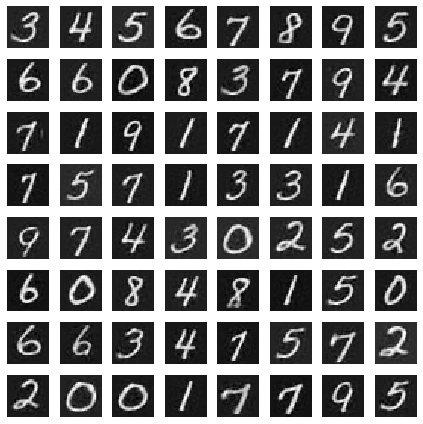

In [12]:
reconstructions = autoencoder.getReconstructions()
for i in range(64):
    plt.subplot(8,8,i+1)
    plt.axis('off')
    plt.imshow(reconstructions[i], cmap='gray', interpolation='none')
    
plt.tight_layout()

# 4. Transfer Learning

## 4.1 The pretrained Classifier

Now we initialize another classifier but this time with the pretrained encoder.

In [13]:
from exercise_code.models import Classifier

hparams = {}
########################################################################
# TODO: Define your hyper parameters here!                             #
########################################################################

hparams = {
    'hidden':64,
    'batch_size':32
}

########################################################################
#                           END OF YOUR CODE                           #
########################################################################
classifier_pretrained = Classifier(hparams, encoder_pretrained, train, val, test)

Now specify another trainer that we will use the pretrained classifier to compare its performance with
the classifier we trained on only the labeled data. You might need to optimize the parameters defined above in order to achieve a reasonable result.

In [14]:
trainer = None

########################################################################
# TODO: Define your trainer! Don't forget the logger.                  # 
# Hint: Choose an appropriate logging frequency in your trainer.       #
########################################################################

trainer = pl.Trainer(
    max_epochs=100,
    gpus=1 if torch.cuda.is_available() else None
)

########################################################################
#                           END OF YOUR CODE                           #
########################################################################
trainer.fit(classifier_pretrained) # train the standard classifier

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type       | Params
---------------------------------------
0 | encoder | Encoder    | 434 K 
1 | model   | Sequential | 650   
---------------------------------------
435 K     Trainable params
0         Non-trainable params
435 K     Total params
1.742     Total estimated model params size (MB)


Epoch 99: 100%|██████████| 8/8 [00:04<00:00,  1.91it/s, loss=7.44e-07, v_num=21]


Let's have a look at the validation accuracy of the two different classifiers and compare them. And don't forget that you can also monitor your training in TensorBoard.

We will only look at the test accuracy and compare our two classifiers with respect to that in the very end.

In [15]:
print("Validation accuracy when training from scratch: {}%".format(classifier.getAcc(classifier.val_dataloader())[1]*100))
print("Validation accuracy with pretraining: {}%".format(classifier_pretrained.getAcc(classifier.val_dataloader())[1]*100))

Validation accuracy when training from scratch: 76.0%
Validation accuracy with pretraining: 60.0%


Now that everything is working, feel free to play around with different architectures. As you've seen, it's really easy to define your model or do changes there.

To pass this submission, you'll need an accuracy of **55%**.

# Save your model & Report Test Accuracy

When you've done with your **hyperparameter tuning**, have achieved **at least 55% validation accuracy** and are happy with your final model, you can save it here.

Before that, please check again whether the number of parameters is below 5 Mio and the file size is below 20 MB.

When your final model is saved, we'll lastly report the test accuracy.

In [16]:
from exercise_code.Util import test_and_save

print("Test accuracy when training from scratch: {}%".format(classifier.getAcc()[1]*100))
print('\nNow to the pretrained classifier:')
test_and_save(classifier_pretrained)

Test accuracy when training from scratch: 73.0%

Now to the pretrained classifier:
Validation-Accuracy: 60.0%
FYI: Your model has 0.435 mio. params.
Great! Your model size is less than 20 MB and will be accepted :)
Your model has been saved and is ready to be submitted. NOW, let's check the test-accuracy.
Test-Accuracy: 56.00000000000001%


In [17]:
# Now zip the folder for upload
from exercise_code.submit import submit_exercise

submit_exercise('exercise08')

relevant folders: ['models', 'exercise_code']
notebooks files: ['1_Autoencoder_PyTorch_Lightning.ipynb', 'Optional-BatchNormalization&Dropout.ipynb', '3.pytorch_lightning.ipynb']
Adding folder models
Adding folder exercise_code
Adding notebook 1_Autoencoder_PyTorch_Lightning.ipynb
Adding notebook Optional-BatchNormalization&Dropout.ipynb
Adding notebook 3.pytorch_lightning.ipynb
Zipping successful! Zip is stored under: /home/jamesqian/Documents/DeepVision/HW8/exercise08.zip


Congrats! You've now finished your first autoencoder and transferred the weights to a classifier! Much easier than in plain numpy, right? But wait, to complete the exercise

# Submission Goals

- Goal: Successfully implement a fully connected autoencoder for MNIST with Pytorch Lightning and transfer the encoder weights to a classifier.

